🚀 Запуск пайплайна обработки данных...
--- 1. STARTING DATA INGESTION ---
Loading Primary Backbone: DEMO_J.xpt
Merging features from: DPQ_J.xpt...
Merging features from: HSQ_J.xpt...
Merging features from: SMQ_J.xpt...
Merging features from: ALQ_J.xpt...
Merging features from: PAQ_J.xpt...
Merging features from: BMX_J.xpt...
Merging features from: BPX_J.xpt...
Merging features from: BIOPRO_J.xpt...
Merging features from: CBC_J.xpt...
Merging features from: HSCRP_J.xpt...
Merging features from: PBCD_J.xpt...
Merging features from: ALB_CR_J.xpt...
Merging features from: VID_J.xpt...
Merging features from: DXX_J.xpt...
--- DATA LOAD COMPLETE. Final Shape: (9254, 44) ---
--- 1. RENAMING ---
--- 2. CREATING IN-ANALYSIS FLAG ---
--- STARTING PROFESSIONAL IMPUTATION (KNN) ---
-> Imputation Complete. Shape: (9254, 38)
--- PIPELINE COMPLETE ---
Full Population Rows (Structure Preserved): 9254
Research-Eligible Rows (In_Analysis=1): 4499
✅ Данные готовы: 4499 записей.


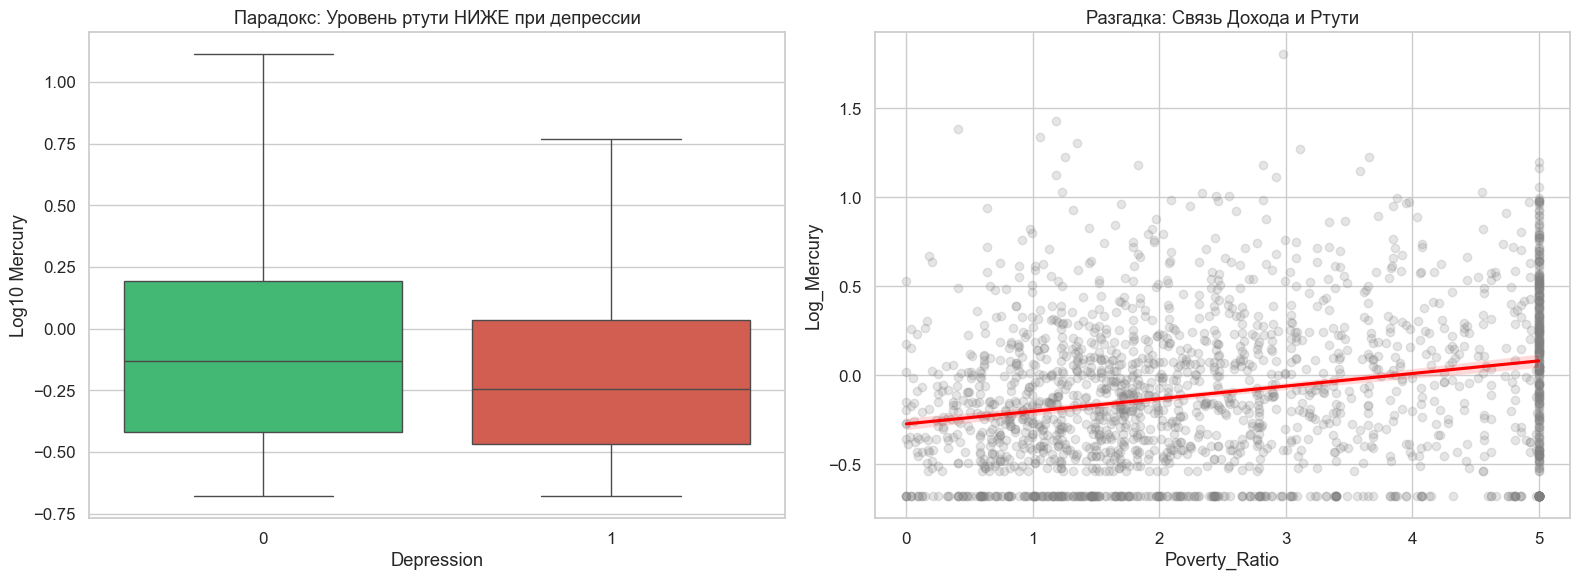

C:\Users\Nikita\AppData\Local\Temp\ipykernel_23592\515967678.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Category', y='Rate', data=res, ax=ax, palette=palette_name, edgecolor='black')
C:\Users\Nikita\AppData\Local\Temp\ipykernel_23592\515967678.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Category', y='Rate', data=res, ax=ax, palette=palette_name, edgecolor='black')
C:\Users\Nikita\AppData\Local\Temp\ipykernel_23592\515967678.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Category', y='Rate', data=res, ax=a

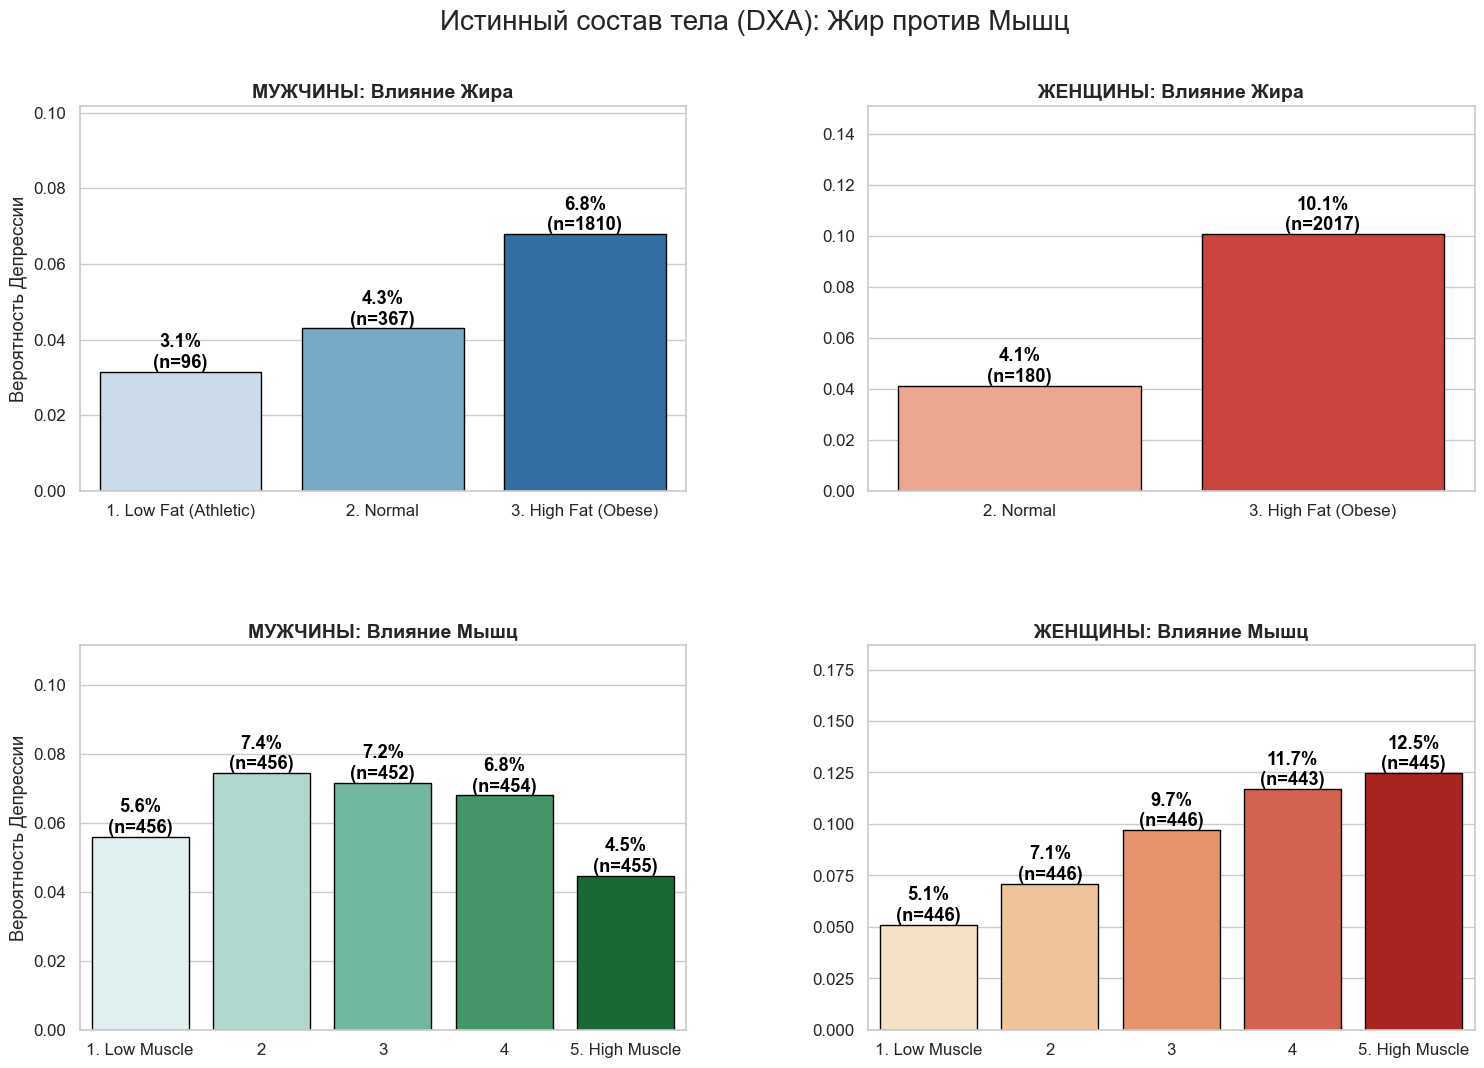

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.stats.weightstats import DescrStatsW

# === 1. ЗАГРУЗКА И НАСТРОЙКА ===
try:
    from src.pipeline.cleaner import clean_pipeline
except ImportError:
    from cleaner import clean_pipeline

print("🚀 Запуск пайплайна обработки данных...")
df = clean_pipeline()

# Оставляем только нужные для анализа строки
df = df[df["In_Analysis"] == 1].copy()

# ПРИНУДИТЕЛЬНАЯ КОНВЕРТАЦИЯ ТИПОВ
# Мы превращаем Depression в строки, чтобы гарантировать совпадение с ключами палитры
df["Depression"] = df["Depression"].astype(str).str.replace(".0", "", regex=False)
# Убираем возможные "nan" строки
df = df[df["Depression"].isin(["0", "1"])]

print(f"✅ Данные готовы: {df.shape[0]} записей.")

# === 2. ПОДГОТОВКА НОВЫХ МЕТРИК ===

# A. Логарифм Ртути
if "Log_Mercury" not in df.columns and "Mercury_Total_ugL" in df.columns:
    df["Log_Mercury"] = np.log10(df["Mercury_Total_ugL"] + 0.01)


# B. Классификация по Жиру (DXA)
def classify_fat_gender(row):
    if pd.isna(row.get("Body_Fat_Pct")):
        return None
    pct = row["Body_Fat_Pct"]
    gender = row["Gender"]  # 0/1

    # Конвертируем gender в int для проверки, на случай если он тоже стал строкой
    try:
        g_val = int(float(gender))
    except:
        return None

    if g_val == 0:  # Мужчины
        if pct < 18:
            return "1. Low Fat (Athletic)"
        elif pct < 25:
            return "2. Normal"
        else:
            return "3. High Fat (Obese)"
    else:  # Женщины
        if pct < 25:
            return "1. Low Fat (Athletic)"
        elif pct < 32:
            return "2. Normal"
        else:
            return "3. High Fat (Obese)"


if "Body_Fat_Pct" in df.columns:
    df["Fat_Category"] = df.apply(classify_fat_gender, axis=1)

# C. Квинтили Мышц
if "Lean_Mass_g" in df.columns:
    df["Muscle_Quintile"] = df.groupby("Gender")["Lean_Mass_g"].transform(
        lambda x: pd.qcut(
            x, 5, labels=["1. Low Muscle", "2", "3", "4", "5. High Muscle"]
        )
    )

# === 3. ВИЗУАЛИЗАЦИЯ ИНСАЙТОВ ===
sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1)

# УНИВЕРСАЛЬНАЯ ПАЛИТРА (Работает и с числами, и со строками)
# Теперь ключи '0' и '1' (строки) точно найдутся
SAFE_PALETTE = {"0": "#2ecc71", "1": "#e74c3c", 0: "#2ecc71", 1: "#e74c3c"}

# --- БЛОК 1: РТУТНЫЙ ПАРАДОКС ---
if "Log_Mercury" in df.columns and "Poverty_Ratio" in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Используем hue='Depression' для совместимости с новыми версиями seaborn
    sns.boxplot(
        x="Depression",
        y="Log_Mercury",
        data=df,
        hue="Depression",
        ax=axes[0],
        palette=SAFE_PALETTE,
        showfliers=False,
        legend=False,
    )
    axes[0].set_title("Парадокс: Уровень ртути НИЖЕ при депрессии")
    axes[0].set_ylabel("Log10 Mercury")

    sns.regplot(
        x="Poverty_Ratio",
        y="Log_Mercury",
        data=df.sample(2000, random_state=42),
        ax=axes[1],
        scatter_kws={"alpha": 0.2, "color": "grey"},
        line_kws={"color": "red"},
    )
    axes[1].set_title("Разгадка: Связь Дохода и Ртути")

    plt.tight_layout()
    plt.show()

# --- БЛОК 2: DXA - ЖИР И МЫШЦЫ ---
if "Fat_Category" in df.columns:
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    def plot_dxa_insight(ax, gender_code, cat_col, title, palette_name):
        # Приводим Gender к строке или числу, смотря как он в df
        # Лучше искать оба варианта
        subset = df[df["Gender"].astype(str) == str(gender_code)].dropna(
            subset=[cat_col]
        )
        if len(subset) == 0:
            return

        # Считаем взвешенное
        stats = []
        for cat in sorted(subset[cat_col].unique()):
            grp = subset[subset[cat_col] == cat]
            if len(grp) > 30:
                # ВАЖНО: Depression сейчас строка '0'/'1', конвертируем в float для среднего
                dep_float = grp["Depression"].astype(float)
                wm = DescrStatsW(dep_float, weights=grp["MEC_Weight"]).mean
                stats.append({"Category": cat, "Rate": wm, "Count": len(grp)})

        res = pd.DataFrame(stats)
        if res.empty:
            return

        sns.barplot(
            x="Category",
            y="Rate",
            data=res,
            ax=ax,
            palette=palette_name,
            edgecolor="black",
        )
        ax.set_title(title, fontweight="bold", fontsize=14)
        ax.set_ylim(0, res["Rate"].max() * 1.5)
        ax.set_xlabel("")
        ax.set_ylabel("Вероятность Депрессии" if str(gender_code) == "0" else "")

        for i, row in res.iterrows():
            ax.text(
                i,
                row["Rate"],
                f"{row['Rate']:.1%}\n(n={row['Count']})",
                ha="center",
                va="bottom",
                fontweight="bold",
                color="black",
            )

    # 1. ЖИР
    plot_dxa_insight(axes[0, 0], 0, "Fat_Category", "МУЖЧИНЫ: Влияние Жира", "Blues")
    plot_dxa_insight(axes[0, 1], 1, "Fat_Category", "ЖЕНЩИНЫ: Влияние Жира", "Reds")

    # 2. МЫШЦЫ
    plot_dxa_insight(axes[1, 0], 0, "Muscle_Quintile", "МУЖЧИНЫ: Влияние Мышц", "BuGn")
    plot_dxa_insight(axes[1, 1], 1, "Muscle_Quintile", "ЖЕНЩИНЫ: Влияние Мышц", "OrRd")

    plt.suptitle("Истинный состав тела (DXA): Жир против Мышц", fontsize=20, y=0.96)
    plt.show()
else:
    print("⚠️ Данные DXA (Body_Fat_Pct) не найдены.")